# Advanced Modeling

In this secion we will analyse models, created in the previous section, using explainability layer and model error analysis error layer.

## Setup

In [ ]:
%pip install ..\scripts -q
print("Instalation Complited!")

Note: you may need to restart the kernel to use updated packages.
Instalation Complited!


## Import

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px

from etl.transformers import * # dependencies for etl pipeline

from pickle import dump, load

In [3]:
Xy_train = pd.read_csv("../data/trainset.csv", index_col=0)
X_train = Xy_train.drop("item_cnt_day", axis="columns")
y_train = Xy_train.loc[:, "item_cnt_day"]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfr_model = load(open("../models/rfr_model.pkl", "rb"))

## Explainability layer

One thing we want to know about our model is why it makes the predictions it makes. We can create explainability layer using `SHAP` module, which will help us answer this question. Best model according to test set is `RandomForestRegressor  so lets take a look on it

First lets build explainer and look, how do our features impact predictions


### RandomForestRegressor

For `RandomForestRegressor` model we will use approximated SHAP values. It will took a lot of time to compute actual SHAP Values for data because of model complexity and amount of data.

In [5]:
from shap import TreeExplainer
explainer = TreeExplainer(rfr_model)

In [6]:
X_train

,date_block_num,item_price,item_price_lag_1,item_cnt_day_lag_1,item_price_lag_2,item_cnt_day_lag_2,item_price_lag_3,item_cnt_day_lag_3,item_price_lag_4,item_cnt_day_lag_4,month,is_NewYear,group
0,0,221.0,221.0,6.0,221.0,6.0,221.0,6.0,221.0,6.0,1,0,1.741761
1,0,347.0,347.0,3.0,347.0,3.0,347.0,3.0,347.0,3.0,1,0,1.741761
2,0,247.0,247.0,1.0,247.0,1.0,247.0,1.0,247.0,1.0,1,0,1.741761
3,0,221.0,221.0,1.0,221.0,1.0,221.0,1.0,221.0,1.0,1,0,1.741761
4,0,127.0,127.0,2.0,127.0,2.0,127.0,2.0,127.0,2.0,1,0,1.379644
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577578,32,119.0,119.0,2.0,119.0,5.0,119.0,1.0,119.0,2.0,9,0,4.901018
1577579,32,119.0,119.0,7.0,119.0,7.0,119.0,4.0,119.0,3.0,9,0,4.901018
1577580,32,179.0,159.0,1.0,139.0,1.0,139.0,10.0,109.0,1.0,9,0,4.901018
1577581,32,629.0,629.0,1.0,629.0,1.0,629.0,1.0,629.0,1.0,9,0,1.730931


In [7]:
explanation = explainer.shap_values(X_train, approximate=True)
explanation[0]

array([-3.51090630e+00, -5.81090100e-03, -3.45698093e-03,  1.75801209e+00,
       -1.85425344e-03,  5.72578461e-01, -7.30281464e-03,  3.41242448e-02,
       -1.88741017e-02,  6.24683713e-03, -8.33752259e-02, -7.98219705e-02,
       -1.13278049e-01])

Next, after we've created shap explainer, we can explore data using different plots

First plot, that we are going to use, is summary plot.

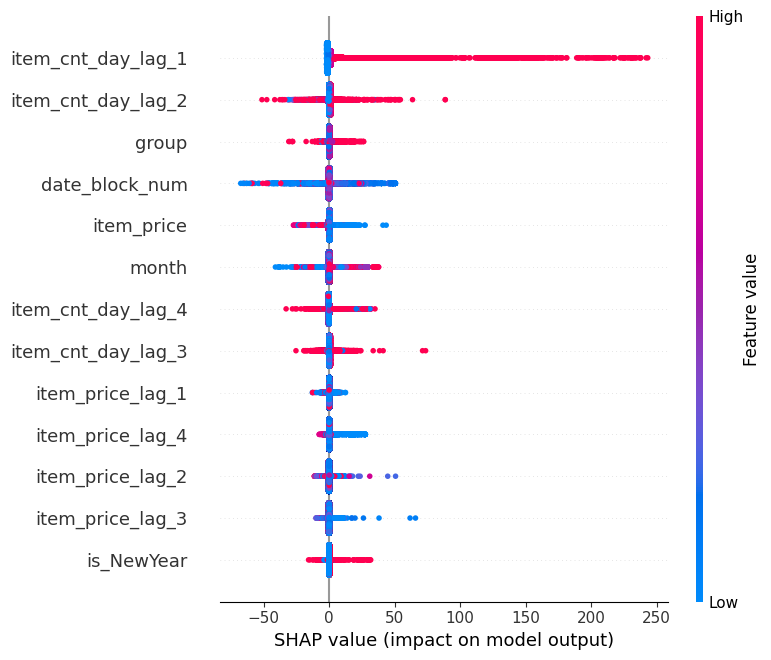

In [8]:
import shap

shap.summary_plot(explanation, X_train, max_display=20)

Based on this graph, we can make some general notes about features and their impact:

1. __Most important features__ : on a `summary_plot` plot we have our features in descending feature importance order. That means, that most useful features are that features, that give us info about sales directly, like `item_cnt_day_lag_1`, `item_cnt_day_lag_2`, `item price` or `group`. Other features, which don't give us direct info about sales, like `month`, or older lags are also usefull, but a bit less than previous features.

2. __Feature value impact on model__: looking at `summary_plot`, we can see how different feature values change model predictions. For example, we can notice, that bigger values of  `item_cnt_day_lag_1` increase predicted values. That means, that bigger sales in previous months increase sales in curent month

	At the same time, bigger values of `item_price` or its lags decrease predicted values. That means, that bigger prices on items decrease sales amount 

On previous graph, we have our features sorted by __mean absolute shap values__, which gives us only info about average impact on model. If we want to find features with high impact on individual records, we can sort features by __max absolute values__

In [9]:
import shap
import numpy as np

max_abs_shap_values = np.max(np.abs(explanation), axis=0)

sorted_indices = np.argsort(max_abs_shap_values)[::-1]
sorted_features = [X_train.columns[i] for i in sorted_indices]
sorted_features

['item_cnt_day_lag_1',
 'item_cnt_day_lag_2',
 'item_cnt_day_lag_3',
 'date_block_num',
 'item_price_lag_3',
 'item_price_lag_2',
 'item_price',
 'month',
 'item_cnt_day_lag_4',
 'is_NewYear',
 'group',
 'item_price_lag_4',
 'item_price_lag_1']

If we look on the previous cell output, we can notice, that features:
- `item_cnt_day_lag_1` 
- `item_cnt_day_lag_2`
- `item_cnt_day_lag_3`
- `date_block_num`
- `item_price_lag_3`

 are feautures, that have most impact on individual records  

Next, lets take a look on single record and study feature impact on predictions. Now, we will recompute actual shap values for individual values.

In [10]:
record = X_train.sample(1, random_state=52)

single_expl = explainer(record)
single_expl

.values =
array([[-0.01100923,  0.07045517, -0.00341139, -0.63823772,  0.02508749,
        -0.22657301,  0.02173365, -0.08003753,  0.01583747, -0.06135384,
        -0.00683325, -0.01758216, -0.25627779]])

.base_values =
array([2.45371896])

.data =
array([[ 20.        , 249.        , 249.        ,   2.        ,
        249.        ,   1.        , 249.        ,   1.        ,
        249.        ,   1.        ,   9.        ,   0.        ,
          1.37964417]])

In [15]:
shap.initjs()

shap.plots.force(single_expl)

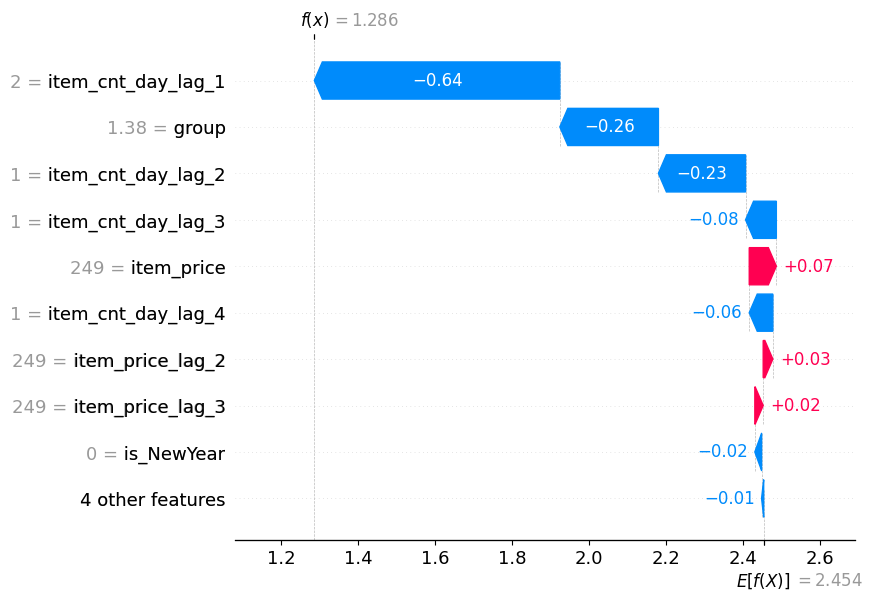

In [16]:
shap.waterfall_plot(single_expl[0])

Based on both `force plot` and `waterfall plot` we can understand, how our prediction was built :

1. `item_cnt_day_lag_1` feature have most impact on prediction. This feature tells model, that __predcition should be lower__, because in previous month sales were also __low__
2. Features `item_cnt_day_lag_2` and `item_cnt_day_lag_3` also tell model that __prediction should be higher__, because two and thee month ago sales where even lower.
3. Also feature `group` make prediction __lower__, because items from this category usually have __lower__ sales
4. Features `item_price`, `item_price_lag_2` and `item_price_lag_3` make predictions a bit __higher__, because for this item price sales are usually __bigger__

Lets take a look on another example

In [23]:
record = X_train[y_train > 5].iloc[:1, ]


single_expl = explainer(record)
single_expl

.values =
array([[ 1.4726273 ,  3.42719362,  1.4776005 , -0.66774677,  0.77821074,
         0.15984576, -0.13135644, -0.0265893 ,  0.41454981,  0.05855028,
         2.51496743, -0.00430628,  0.84332305]])

.base_values =
array([2.45371896])

.data =
array([[ 0.        , 13.        , 13.        ,  1.        , 13.        ,
         1.        , 13.        ,  1.        , 13.        ,  1.        ,
         1.        ,  0.        , 12.80613497]])

In [24]:
shap.plots.force(single_expl)

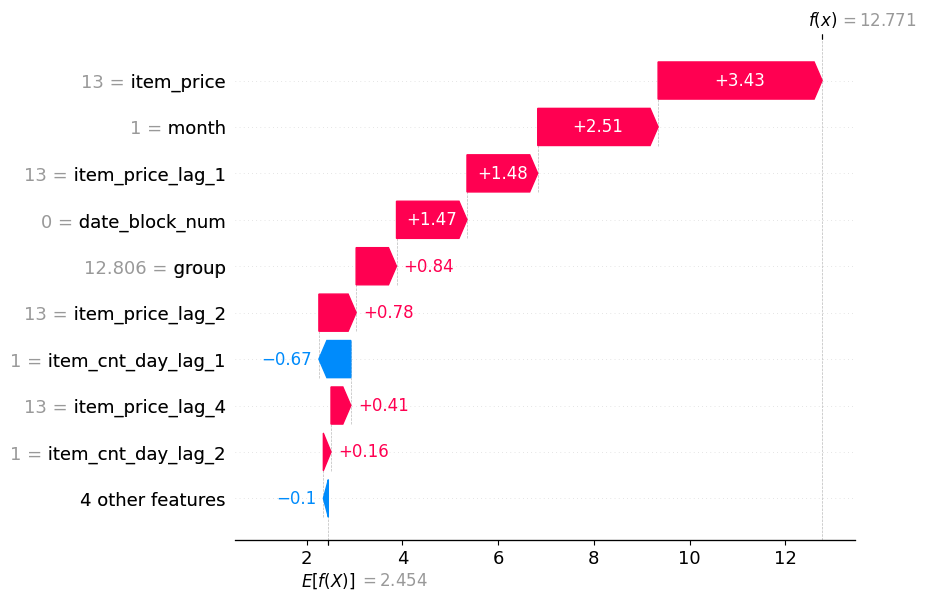

In [25]:
shap.waterfall_plot(single_expl[0])

Based on both `force plot` and `waterfall plot` we can understand, how our prediction was built :

1. Features `item_price`, `month`, `item_price_lag_1`, and `group` make prediction bigger. `item_price` is low, it is a start of a year, so sales are increased, in previous two month sales of this item were high and usually items from this group have a high sales. 
2. On the other hand, `item_cnt_day_lag_1` feature make a little negative impact on prediction because in previous month sales of this item were low.

## Model Error Analysis Layer 

In oreder to evaluate eror analysis, we need to create a new dataset, that contains both the target and preditctions, difference between them and so on.

In [26]:
Xy_train = pd.read_csv("../data/trainset.csv", index_col=0)
Xy_test = pd.read_csv("../data/testset.csv", index_col=0) 

X_train = Xy_train.drop("item_cnt_day", axis="columns")
y_train = Xy_train.loc[:, "item_cnt_day"]

X_test = Xy_test.drop("item_cnt_day", axis="columns")
y_test = Xy_test.loc[:, "item_cnt_day"]

In [27]:
y_pred = rfr_model.predict(X_test)
y_pred

array([1.28436012, 2.05621686, 1.06533244, ..., 1.53514012, 1.80015848,
       1.16129237])

In [28]:
from sklearn.metrics import root_mean_squared_error

eal = X_test.copy()
eal["target"] = y_test
eal["predictions"] = y_pred
eal["error"] = eal.apply(lambda x: abs(x["target"] - x["predictions"]), axis="columns")
eal

,date_block_num,item_price,item_price_lag_1,item_cnt_day_lag_1,item_price_lag_2,item_cnt_day_lag_2,item_price_lag_3,item_cnt_day_lag_3,item_price_lag_4,item_cnt_day_lag_4,month,is_NewYear,group,target,predictions,error
1577583,33,399.0,415.92,1.0,699.0,1.0,698.5,1.0,699.0,4.0,10,0,1.741761,1.0,1.284360,0.284360
1577584,33,300.0,300.00,1.0,300.0,2.0,300.0,1.0,300.0,2.0,10,0,2.443934,3.0,2.056217,0.943783
1577585,33,420.0,420.00,1.0,420.0,1.0,420.0,1.0,420.0,1.0,10,0,1.730931,1.0,1.065332,0.065332
1577586,33,3300.0,3300.00,1.0,3300.0,1.0,3300.0,1.0,3300.0,1.0,10,0,2.443934,1.0,1.022063,0.022063
1577587,33,58.0,58.00,1.0,58.0,1.0,58.0,1.0,58.0,1.0,10,0,1.741761,1.0,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609108,33,119.0,119.00,3.0,119.0,2.0,119.0,5.0,119.0,1.0,10,0,4.901018,6.0,4.635097,1.364903
1609109,33,119.0,119.00,1.0,119.0,7.0,119.0,7.0,119.0,4.0,10,0,4.901018,2.0,3.142041,1.142041
1609110,33,179.0,179.00,3.0,159.0,1.0,139.0,1.0,139.0,10.0,10,0,4.901018,1.0,1.535140,0.535140
1609111,33,629.0,629.00,1.0,629.0,1.0,629.0,1.0,629.0,1.0,10,0,1.730931,1.0,1.800158,0.800158


<Axes: xlabel='error'>

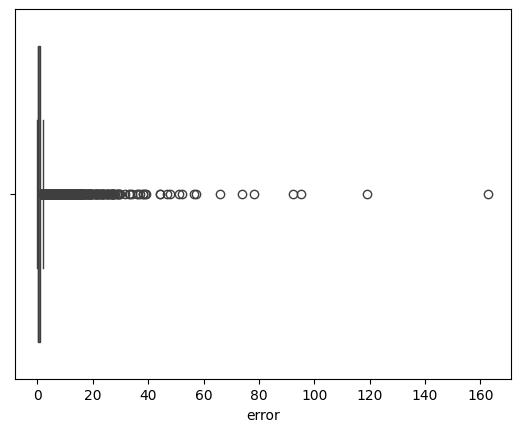

In [29]:
sns.boxplot(data=eal, x="error")

After we've created this dataset, we can take a study feature values impact on predictions and errors. Most of features in dataset are continues, so we can split them by bins and take a look on a mean error

In [30]:
def feature_check(feature):
    x = eal.copy()
    x[f'{feature}_bins'] = list(pd.cut(x[feature], 6, retbins=False, labels=range(6)))
    print(x.groupby(f"{feature}_bins")["error"].mean().reset_index().to_string())
    print(pd.cut(x[feature], 6, retbins=True, labels=range(6))[1])
    
    sns.catplot(data=x, x=f'{feature}_bins', y="error", kind="box")
    plt.title(f"Errors by different {feature} bins")
    plt.show()

   item_price_bins     error
0                0  0.901323
1                1  1.137416
2                2  0.754885
3                3  0.703944
4                4  0.768754
5                5  0.348978
[-4.1999010e+01  7.1658250e+03  1.4330660e+04  2.1495495e+04
  2.8660330e+04  3.5825165e+04  4.2990000e+04]


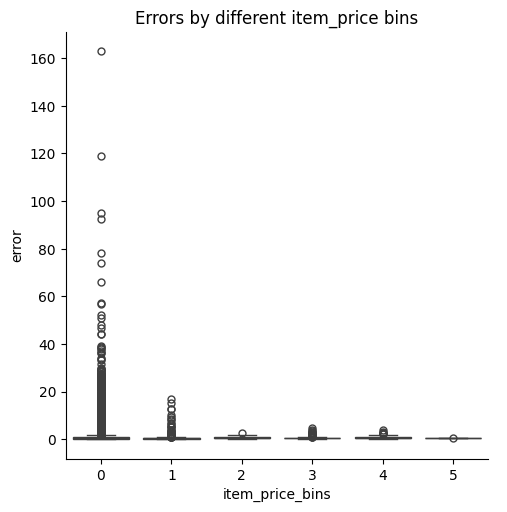

   group_bins      error
0           0   0.889471
1           1   2.927882
2           5  31.327109
[ 1.31396826 12.3256292  23.27161423 34.21759926 45.16358429 56.10956932
 67.05555435]


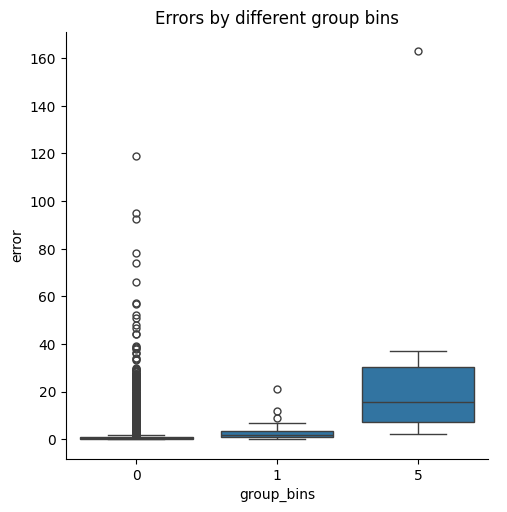

   item_cnt_day_lag_1_bins      error
0                        0   0.832129
1                        1  17.178718
2                        2  29.164639
3                        3  39.936045
4                        4  95.160242
5                        5  65.177490
[ -1.259       42.16666667  85.33333333 128.5        171.66666667
 214.83333333 258.        ]


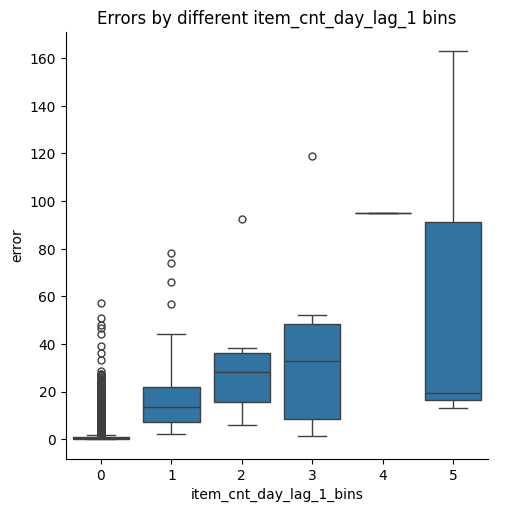

   item_price_lag_1_bins     error
0                      0  0.901015
1                      1  1.149050
2                      2  0.771240
3                      3  0.702433
4                      4  0.765563
5                      5  0.348978
[-4.24895000e+01  7.16541667e+03  1.43303333e+04  2.14952500e+04
  2.86601667e+04  3.58250833e+04  4.29900000e+04]


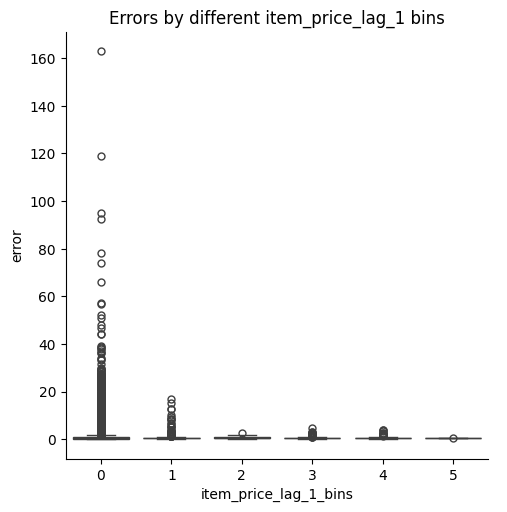

   item_cnt_day_lag_2_bins      error
0                        0   0.840646
1                        1  19.018173
2                        2  23.869925
3                        3  53.549687
4                        4  95.160242
5                        5  19.385470
[ -1.285  46.5    94.    141.5   189.    236.5   284.   ]


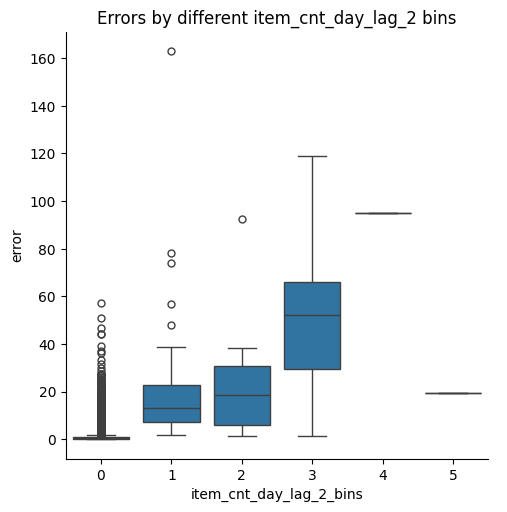

   item_price_lag_2_bins     error
0                      0  0.900983
1                      1  1.144345
2                      2  0.902192
3                      3  0.654734
4                      4  0.765563
5                      5  0.348978
[-3.89860000e+01  7.16833333e+03  1.43326667e+04  2.14970000e+04
  2.86613333e+04  3.58256667e+04  4.29900000e+04]


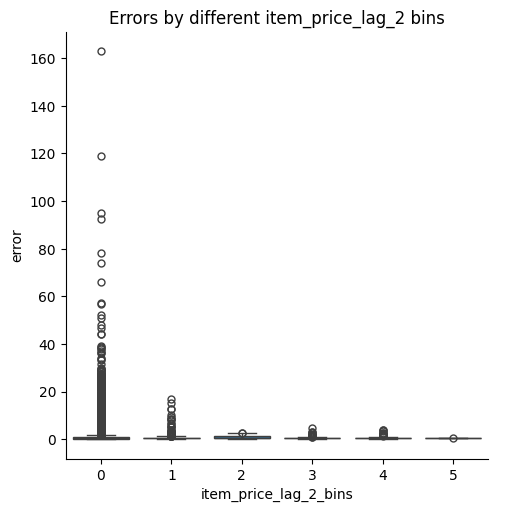

   item_cnt_day_lag_3_bins       error
0                        0    0.844437
1                        1   16.485025
2                        2   29.447914
3                        3   63.908842
4                        4  162.868553
5                        5   19.385470
[ -1.3  49.   99.  149.  199.  249.  299. ]


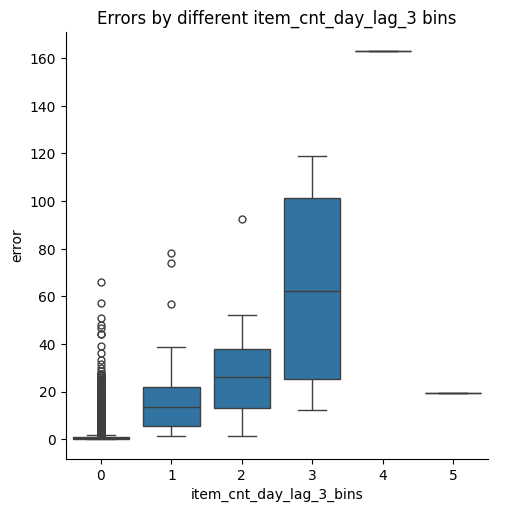

   item_price_lag_3_bins     error
0                      0  0.900845
1                      1  1.160189
2                      2  0.873764
3                      3  0.655838
4                      4  0.765563
5                      5  0.348978
[-3.89860000e+01  7.16833333e+03  1.43326667e+04  2.14970000e+04
  2.86613333e+04  3.58256667e+04  4.29900000e+04]


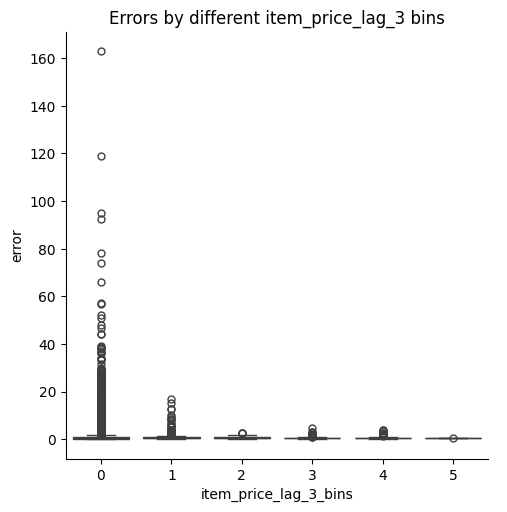

   item_cnt_day_lag_4_bins      error
0                        0   0.845587
1                        1  15.209701
2                        2  36.980538
3                        3  60.803546
4                        5  19.385470
[ -2.33  53.   108.   163.   218.   273.   328.  ]


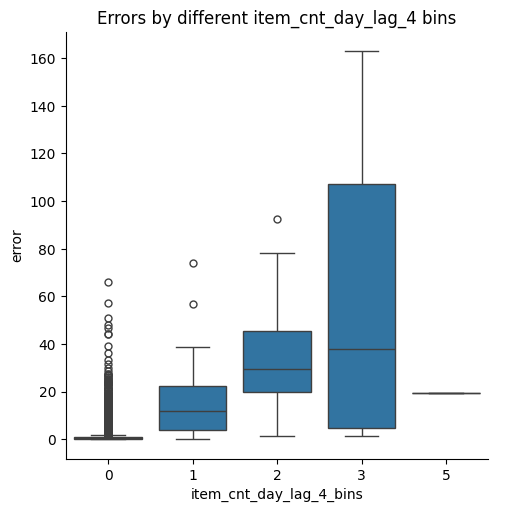

   item_price_lag_4_bins     error
0                      0  0.900862
1                      1  1.154573
2                      2  0.831846
3                      3  0.657944
4                      4  0.765563
5                      5  0.348978
[-4.24895000e+01  7.16541667e+03  1.43303333e+04  2.14952500e+04
  2.86601667e+04  3.58250833e+04  4.29900000e+04]


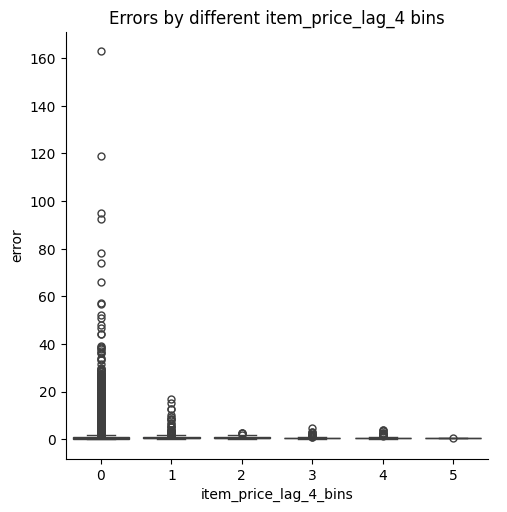

   target_bins      error
0            0   0.858399
1            1  17.933613
2            2  18.040180
3            3  26.809483
4            4  19.651956
5            5  57.272856
[ -1.23        37.33333333  75.66666667 114.         152.33333333
 190.66666667 229.        ]


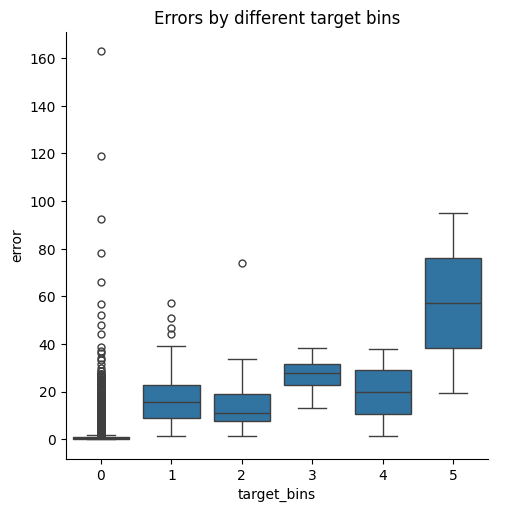

In [31]:
features_to_study = ["item_price", "group", "item_cnt_day_lag_1", "item_price_lag_1", "item_cnt_day_lag_2", "item_price_lag_2","item_cnt_day_lag_3", "item_price_lag_3","item_cnt_day_lag_4", "item_price_lag_4", "target"]
for feature in features_to_study:
    feature_check(feature)

In [32]:
eal.sort_values(by="target", ascending=False)[:15]

,date_block_num,item_price,item_price_lag_1,item_cnt_day_lag_1,item_price_lag_2,item_cnt_day_lag_2,item_price_lag_3,item_cnt_day_lag_3,item_price_lag_4,item_cnt_day_lag_4,month,is_NewYear,group,target,predictions,error
1592631,33,5.0,5.000000,237.0,5.0,284.0,5.000000,299.0,5.000000,328.0,10,0,2.563287,229.0,209.614530,19.385470
1581113,33,399.0,399.000000,194.0,399.0,194.0,399.000000,194.0,399.000000,194.0,10,0,2.443934,194.0,98.839758,95.160242
1587071,33,5.0,5.000000,120.0,5.0,83.0,5.000000,123.0,5.000000,200.0,10,0,2.563287,167.0,128.951441,38.048559
1602325,33,5.0,5.000000,151.0,5.0,149.0,5.000000,100.0,5.000000,197.0,10,0,2.563287,165.0,166.255353,1.255353
1598891,33,799.0,799.000000,152.0,799.0,152.0,799.000000,152.0,799.000000,152.0,10,0,3.591801,152.0,122.539615,29.460385
1581284,33,599.0,599.000000,125.0,599.0,125.0,599.000000,125.0,599.000000,125.0,10,0,2.563287,125.0,86.698927,38.301073
1582114,33,325.0,172.025316,258.0,140.0,87.0,143.571429,105.0,248.571429,120.0,10,0,67.055554,123.0,109.721555,13.278445
1598892,33,1199.0,1199.000000,115.0,1199.0,115.0,1199.000000,115.0,1199.000000,115.0,10,0,2.563908,115.0,88.801972,26.198028
1607765,33,5.0,5.000000,88.0,5.0,110.0,5.000000,94.0,5.000000,98.0,10,0,2.563287,111.0,104.840951,6.159049
1581118,33,599.0,1499.000000,54.0,1499.0,54.0,1499.000000,54.0,1499.000000,54.0,10,0,3.591801,102.0,28.107807,73.892193


__Summary__:

Studying graphs, we can notice, that for some feature values, our model can underperform. Feature values, which produce mots errors are:
1. __low values__ of `item_price` feature 
2. __large values__ of `group` feature
3. __large values__ of `item_cnt_day_lag`
4. __low values__ of `item_price_lag_1` feature. Generally, errors for different bins of price lags have quite low error, but there are a lot of outliers for bins with low values 

Also I've noticed, that model have a poor performance in prediction big target.

### Sampling debug

In this section, we will focus on finding samples, that influence error rate. In this section, I want to try different methods and their combination in order to find object, which possibly can influence my model.

Initial Test Error: __3.1456586254381125__

#### Isolation Forest

In [252]:
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import IsolationForest

isof = IsolationForest(n_jobs=-1)

eal_train = X_train.copy()
eal_train["target"] = y_train
eal_train["prediction"] = rfr_model.predict(X_train)
eal_train["error"] = abs(eal_train["target"] - eal_train["prediction"])
eal_train["outliers"] = isof.fit_predict(X_train)

eal_train

,date_block_num,item_price,item_price_lag_1,item_cnt_day_lag_1,item_price_lag_2,item_cnt_day_lag_2,item_price_lag_3,item_cnt_day_lag_3,item_price_lag_4,item_cnt_day_lag_4,month,is_NewYear,group,target,prediction,error,outliers
0,0,221.0,221.0,6.0,221.0,6.0,221.0,6.0,221.0,6.0,1,0,1.741761,1.0,1.000000,0.000000,1
1,0,347.0,347.0,3.0,347.0,3.0,347.0,3.0,347.0,3.0,1,0,1.741761,1.0,1.000000,0.000000,1
2,0,247.0,247.0,1.0,247.0,1.0,247.0,1.0,247.0,1.0,1,0,1.741761,1.0,1.000000,0.000000,1
3,0,221.0,221.0,1.0,221.0,1.0,221.0,1.0,221.0,1.0,1,0,1.741761,1.0,1.000000,0.000000,1
4,0,127.0,127.0,2.0,127.0,2.0,127.0,2.0,127.0,2.0,1,0,1.379644,1.0,1.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577578,32,119.0,119.0,2.0,119.0,5.0,119.0,1.0,119.0,2.0,9,0,4.901018,3.0,2.528103,0.471897,1
1577579,32,119.0,119.0,7.0,119.0,7.0,119.0,4.0,119.0,3.0,9,0,4.901018,1.0,3.097030,2.097030,-1
1577580,32,179.0,159.0,1.0,139.0,1.0,139.0,10.0,109.0,1.0,9,0,4.901018,3.0,2.724047,0.275953,1
1577581,32,629.0,629.0,1.0,629.0,1.0,629.0,1.0,629.0,1.0,9,0,1.730931,1.0,1.945069,0.945069,1


In [38]:
from sklearn.ensemble import RandomForestRegressor

X_train_v1 = eal_train[eal_train["outliers"] == 1]
rfr_v1 = RandomForestRegressor(max_depth=np.int64(432), min_samples_leaf=np.int64(2), min_samples_split=np.int64(7), n_estimators=np.int64(333), n_jobs=-1)
y_train_v1 = X_train_v1["target"]
X_train_v1.drop(["target", "prediction", "error", "outliers"], axis="columns", inplace=True)

rfr_v1.fit(X_train_v1, y_train_v1)

C:\Users\masam\AppData\Local\Temp\ipykernel_14560\3855487893.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_v1.drop(["target", "prediction", "error", "outliers"], axis="columns", inplace=True)


RandomForestRegressor(max_depth=432, min_samples_leaf=2, min_samples_split=7,
                      n_estimators=333, n_jobs=-1)

In [40]:
root_mean_squared_error(y_test, rfr_v1.predict(X_test))

3.6024971628778113

#### LOF

In [41]:
from sklearn.metrics import root_mean_squared_error
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_jobs=-1)

eal_train = X_train.copy()
eal_train["target"] = y_train
eal_train["prediction"] = rfr_model.predict(X_train)
eal_train["error"] = abs(eal_train["target"] - eal_train["prediction"])
eal_train["outliers"] = lof.fit_predict(X_train)

eal_train

,date_block_num,item_price,item_price_lag_1,item_cnt_day_lag_1,item_price_lag_2,item_cnt_day_lag_2,item_price_lag_3,item_cnt_day_lag_3,item_price_lag_4,item_cnt_day_lag_4,month,is_NewYear,group,target,prediction,error,outliers
0,0,221.0,221.0,6.0,221.0,6.0,221.0,6.0,221.0,6.0,1,0,1.741761,1.0,1.000000,0.000000,1
1,0,347.0,347.0,3.0,347.0,3.0,347.0,3.0,347.0,3.0,1,0,1.741761,1.0,1.000000,0.000000,1
2,0,247.0,247.0,1.0,247.0,1.0,247.0,1.0,247.0,1.0,1,0,1.741761,1.0,1.000000,0.000000,1
3,0,221.0,221.0,1.0,221.0,1.0,221.0,1.0,221.0,1.0,1,0,1.741761,1.0,1.000000,0.000000,1
4,0,127.0,127.0,2.0,127.0,2.0,127.0,2.0,127.0,2.0,1,0,1.379644,1.0,1.000000,0.000000,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577578,32,119.0,119.0,2.0,119.0,5.0,119.0,1.0,119.0,2.0,9,0,4.901018,3.0,2.528103,0.471897,1
1577579,32,119.0,119.0,7.0,119.0,7.0,119.0,4.0,119.0,3.0,9,0,4.901018,1.0,3.097030,2.097030,1
1577580,32,179.0,159.0,1.0,139.0,1.0,139.0,10.0,109.0,1.0,9,0,4.901018,3.0,2.724047,0.275953,1
1577581,32,629.0,629.0,1.0,629.0,1.0,629.0,1.0,629.0,1.0,9,0,1.730931,1.0,1.945069,0.945069,1


In [43]:
from sklearn.ensemble import RandomForestRegressor

X_train_v2 = eal_train[eal_train["outliers"] == 1]
rfr_v2 = RandomForestRegressor(max_depth=np.int64(432), min_samples_leaf=np.int64(2), min_samples_split=np.int64(7), n_estimators=np.int64(333), n_jobs=-1)
y_train_v2 = X_train_v2["target"]
X_train_v2.drop(["target", "prediction", "error", "outliers"], axis="columns", inplace=True)

rfr_v2.fit(X_train_v2, y_train_v2)

C:\Users\masam\AppData\Local\Temp\ipykernel_14560\2888081624.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_v2.drop(["target", "prediction", "error", "outliers"], axis="columns", inplace=True)


RandomForestRegressor(max_depth=432, min_samples_leaf=2, min_samples_split=7,
                      n_estimators=333, n_jobs=-1)

In [46]:
root_mean_squared_error(y_test, rfr_v2.predict(X_test))

3.191635609121802

#### Residual error analysis (error >= 3)

In [13]:
from sklearn.metrics import root_mean_squared_error
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_jobs=-1)

eal_train = X_train.copy()
eal_train["target"] = y_train
eal_train["prediction"] = rfr_model.predict(X_train)
eal_train["error"] = abs(eal_train["target"] - eal_train["prediction"])
eal_train["outliers"] = eal_train["error"].apply(lambda x :  -1 if x >= 3 else 1)

eal_train

,date_block_num,item_price,item_price_lag_1,item_cnt_day_lag_1,item_price_lag_2,item_cnt_day_lag_2,item_price_lag_3,item_cnt_day_lag_3,item_price_lag_4,item_cnt_day_lag_4,month,is_NewYear,group,target,prediction,error,outliers
0,0,221.0,221.0,6.0,221.0,6.0,221.0,6.0,221.0,6.0,1,0,1.741761,1.0,1.000000,0.000000,1
1,0,347.0,347.0,3.0,347.0,3.0,347.0,3.0,347.0,3.0,1,0,1.741761,1.0,1.000000,0.000000,1
2,0,247.0,247.0,1.0,247.0,1.0,247.0,1.0,247.0,1.0,1,0,1.741761,1.0,1.000000,0.000000,1
3,0,221.0,221.0,1.0,221.0,1.0,221.0,1.0,221.0,1.0,1,0,1.741761,1.0,1.000000,0.000000,1
4,0,127.0,127.0,2.0,127.0,2.0,127.0,2.0,127.0,2.0,1,0,1.379644,1.0,1.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577578,32,119.0,119.0,2.0,119.0,5.0,119.0,1.0,119.0,2.0,9,0,4.901018,3.0,2.528103,0.471897,1
1577579,32,119.0,119.0,7.0,119.0,7.0,119.0,4.0,119.0,3.0,9,0,4.901018,1.0,3.097030,2.097030,1
1577580,32,179.0,159.0,1.0,139.0,1.0,139.0,10.0,109.0,1.0,9,0,4.901018,3.0,2.724047,0.275953,1
1577581,32,629.0,629.0,1.0,629.0,1.0,629.0,1.0,629.0,1.0,9,0,1.730931,1.0,1.945069,0.945069,1


In [49]:
from sklearn.ensemble import RandomForestRegressor

X_train_v3 = eal_train[eal_train["outliers"] == 1]
rfr_v3 = RandomForestRegressor(max_depth=np.int64(432), min_samples_leaf=np.int64(2), min_samples_split=np.int64(7), n_estimators=np.int64(333), n_jobs=-1)
y_train_v3 = X_train_v3["target"]
X_train_v3.drop(["target", "prediction", "error", "outliers"], axis="columns", inplace=True)

rfr_v3.fit(X_train_v3, y_train_v3)

C:\Users\masam\AppData\Local\Temp\ipykernel_14560\2613938198.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_v3.drop(["target", "prediction", "error", "outliers"], axis="columns", inplace=True)


RandomForestRegressor(max_depth=432, min_samples_leaf=2, min_samples_split=7,
                      n_estimators=333, n_jobs=-1)

In [50]:
root_mean_squared_error(y_test, rfr_v3.predict(X_test))

3.0773391906617937

#### Residual error analysis (error >= 2)

In [254]:
from sklearn.metrics import root_mean_squared_error
from sklearn.neighbors import LocalOutlierFactor


eal_train = X_train.copy()
eal_train["target"] = y_train
eal_train["prediction"] = rfr_model.predict(X_train)
eal_train["error"] = abs(eal_train["target"] - eal_train["prediction"])
eal_train["outliers"] = eal_train["error"].apply(lambda x :  -1 if x >= 2 else 1)

eal_train

,date_block_num,item_price,item_price_lag_1,item_cnt_day_lag_1,item_price_lag_2,item_cnt_day_lag_2,item_price_lag_3,item_cnt_day_lag_3,item_price_lag_4,item_cnt_day_lag_4,month,is_NewYear,group,target,prediction,error,outliers
0,0,221.0,221.0,6.0,221.0,6.0,221.0,6.0,221.0,6.0,1,0,1.741761,1.0,1.000000,0.000000,1
1,0,347.0,347.0,3.0,347.0,3.0,347.0,3.0,347.0,3.0,1,0,1.741761,1.0,1.000000,0.000000,1
2,0,247.0,247.0,1.0,247.0,1.0,247.0,1.0,247.0,1.0,1,0,1.741761,1.0,1.000000,0.000000,1
3,0,221.0,221.0,1.0,221.0,1.0,221.0,1.0,221.0,1.0,1,0,1.741761,1.0,1.000000,0.000000,1
4,0,127.0,127.0,2.0,127.0,2.0,127.0,2.0,127.0,2.0,1,0,1.379644,1.0,1.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577578,32,119.0,119.0,2.0,119.0,5.0,119.0,1.0,119.0,2.0,9,0,4.901018,3.0,2.528103,0.471897,1
1577579,32,119.0,119.0,7.0,119.0,7.0,119.0,4.0,119.0,3.0,9,0,4.901018,1.0,3.097030,2.097030,-1
1577580,32,179.0,159.0,1.0,139.0,1.0,139.0,10.0,109.0,1.0,9,0,4.901018,3.0,2.724047,0.275953,1
1577581,32,629.0,629.0,1.0,629.0,1.0,629.0,1.0,629.0,1.0,9,0,1.730931,1.0,1.945069,0.945069,1


In [255]:
eal_train[eal_train["outliers"] == -1]

,date_block_num,item_price,item_price_lag_1,item_cnt_day_lag_1,item_price_lag_2,item_cnt_day_lag_2,item_price_lag_3,item_cnt_day_lag_3,item_price_lag_4,item_cnt_day_lag_4,month,is_NewYear,group,target,prediction,error,outliers
30,0,91.0,91.0,1.0,91.0,1.0,91.0,1.0,91.0,1.0,1,0,2.443934,1.0,3.099334,2.099334,-1
35,0,71.0,71.0,1.0,71.0,1.0,71.0,1.0,71.0,1.0,1,0,2.443934,1.0,3.074910,2.074910,-1
45,0,58.0,58.0,1.0,58.0,1.0,58.0,1.0,58.0,1.0,1,0,2.563287,1.0,3.074910,2.074910,-1
50,0,58.0,58.0,1.0,58.0,1.0,58.0,1.0,58.0,1.0,1,0,2.563287,1.0,3.074910,2.074910,-1
51,0,58.0,58.0,1.0,58.0,1.0,58.0,1.0,58.0,1.0,1,0,2.563287,1.0,3.074910,2.074910,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577472,32,399.0,499.0,2.0,499.0,2.0,499.0,2.0,499.0,2.0,9,0,2.563287,6.0,1.363357,4.636643,-1
1577510,32,999.0,500.0,16.0,750.0,24.0,101.5,10.0,500.0,13.0,9,0,13.899421,12.0,15.231275,3.231275,-1
1577551,32,399.0,399.0,7.0,399.0,7.0,399.0,7.0,399.0,7.0,9,0,1.741761,1.0,6.215289,5.215289,-1
1577552,32,699.0,699.0,7.0,699.0,7.0,699.0,7.0,699.0,7.0,9,0,1.741761,1.0,3.441114,2.441114,-1


In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train_v4 = eal_train[eal_train["outliers"] == 1]
rfr_v4 = RandomForestRegressor(max_depth=np.int64(432), min_samples_leaf=np.int64(2), min_samples_split=np.int64(7), n_estimators=np.int64(333), n_jobs=-1)
y_train_v4 = X_train_v4["target"]
X_train_v4.drop(["target", "prediction", "error", "outliers"], axis="columns", inplace=True)

rfr_v4.fit(X_train_v4, y_train_v4)

C:\Users\masam\AppData\Local\Temp\ipykernel_8244\30812789.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_v4.drop(["target", "prediction", "error", "outliers"], axis="columns", inplace=True)


RandomForestRegressor(max_depth=432, min_samples_leaf=2, min_samples_split=7,
                      n_estimators=333, n_jobs=-1)

In [17]:
root_mean_squared_error(y_test, rfr_v4.predict(X_test))

3.007909247550287

#### Methods combinations

In [7]:
from sklearn.metrics import root_mean_squared_error
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

lof = LocalOutlierFactor(n_jobs=-1)
isof = IsolationForest(n_jobs=-1)

eal_train = X_train.copy()
eal_train["target"] = y_train
eal_train["prediction"] = rfr_model.predict(X_train)
eal_train["error"] = abs(eal_train["target"] - eal_train["prediction"])
eal_train["outliers_lof"] = lof.fit_predict(X_train)
eal_train["outliers_isof"] = isof.fit_predict(X_train)
eal_train["outliers_rea"] = eal_train["error"].apply(lambda x : -1 if x >= 3 else 1)

eal_train

,date_block_num,item_price,item_price_lag_1,item_cnt_day_lag_1,item_price_lag_2,item_cnt_day_lag_2,item_price_lag_3,item_cnt_day_lag_3,item_price_lag_4,item_cnt_day_lag_4,month,is_NewYear,group,target,prediction,error,outliers_lof,outliers_isof,outliers_rea
0,0,221.0,221.0,6.0,221.0,6.0,221.0,6.0,221.0,6.0,1,0,1.741761,1.0,1.000000,0.000000,1,1,1
1,0,347.0,347.0,3.0,347.0,3.0,347.0,3.0,347.0,3.0,1,0,1.741761,1.0,1.000000,0.000000,1,1,1
2,0,247.0,247.0,1.0,247.0,1.0,247.0,1.0,247.0,1.0,1,0,1.741761,1.0,1.000000,0.000000,1,1,1
3,0,221.0,221.0,1.0,221.0,1.0,221.0,1.0,221.0,1.0,1,0,1.741761,1.0,1.000000,0.000000,1,1,1
4,0,127.0,127.0,2.0,127.0,2.0,127.0,2.0,127.0,2.0,1,0,1.379644,1.0,1.000000,0.000000,-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577578,32,119.0,119.0,2.0,119.0,5.0,119.0,1.0,119.0,2.0,9,0,4.901018,3.0,2.528103,0.471897,1,1,1
1577579,32,119.0,119.0,7.0,119.0,7.0,119.0,4.0,119.0,3.0,9,0,4.901018,1.0,3.097030,2.097030,1,-1,1
1577580,32,179.0,159.0,1.0,139.0,1.0,139.0,10.0,109.0,1.0,9,0,4.901018,3.0,2.724047,0.275953,1,-1,1
1577581,32,629.0,629.0,1.0,629.0,1.0,629.0,1.0,629.0,1.0,9,0,1.730931,1.0,1.945069,0.945069,1,1,1


##### Inersection of all methods

In [53]:
eal_train["intersections"] = eal_train["outliers_lof"] | eal_train["outliers_isof"] | eal_train["outliers_rea"]
eal_train

,date_block_num,item_price,item_price_lag_1,item_cnt_day_lag_1,item_price_lag_2,item_cnt_day_lag_2,item_price_lag_3,item_cnt_day_lag_3,item_price_lag_4,item_cnt_day_lag_4,month,is_NewYear,group,target,prediction,error,outliers_lof,outliers_isof,outliers_rea,intersections
0,0,221.0,221.0,6.0,221.0,6.0,221.0,6.0,221.0,6.0,1,0,1.741761,1.0,1.000000,0.000000,1,1,1,1
1,0,347.0,347.0,3.0,347.0,3.0,347.0,3.0,347.0,3.0,1,0,1.741761,1.0,1.000000,0.000000,1,1,1,1
2,0,247.0,247.0,1.0,247.0,1.0,247.0,1.0,247.0,1.0,1,0,1.741761,1.0,1.000000,0.000000,1,1,1,1
3,0,221.0,221.0,1.0,221.0,1.0,221.0,1.0,221.0,1.0,1,0,1.741761,1.0,1.000000,0.000000,1,1,1,1
4,0,127.0,127.0,2.0,127.0,2.0,127.0,2.0,127.0,2.0,1,0,1.379644,1.0,1.000000,0.000000,-1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577578,32,119.0,119.0,2.0,119.0,5.0,119.0,1.0,119.0,2.0,9,0,4.901018,3.0,2.528103,0.471897,1,1,1,1
1577579,32,119.0,119.0,7.0,119.0,7.0,119.0,4.0,119.0,3.0,9,0,4.901018,1.0,3.097030,2.097030,1,-1,1,-1
1577580,32,179.0,159.0,1.0,139.0,1.0,139.0,10.0,109.0,1.0,9,0,4.901018,3.0,2.724047,0.275953,1,1,1,1
1577581,32,629.0,629.0,1.0,629.0,1.0,629.0,1.0,629.0,1.0,9,0,1.730931,1.0,1.945069,0.945069,1,1,1,1


In [57]:
from sklearn.ensemble import RandomForestRegressor

X_train_v4 = eal_train[eal_train["intersections"] == 1]
rfr_v4 = RandomForestRegressor(max_depth=np.int64(432), min_samples_leaf=np.int64(2), min_samples_split=np.int64(7), n_estimators=np.int64(333), n_jobs=-1)
y_train_v4 = X_train_v4["target"]
X_train_v4.drop(["target", "prediction", "error", "outliers_lof", "outliers_rea", "outliers_isof", "intersections"], axis="columns", inplace=True)

rfr_v4.fit(X_train_v4, y_train_v4)

C:\Users\masam\AppData\Local\Temp\ipykernel_14560\3308726260.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_v4.drop(["target", "prediction", "error", "outliers_lof", "outliers_rea", "outliers_isof", "intersections"], axis="columns", inplace=True)


RandomForestRegressor(max_depth=432, min_samples_leaf=2, min_samples_split=7,
                      n_estimators=333, n_jobs=-1)

In [58]:
root_mean_squared_error(y_test, rfr_v4.predict(X_test))

3.7609597945285995

#### Union of all methods

In [59]:
eal_train["intersections"] = eal_train["outliers_lof"] & eal_train["outliers_isof"] & eal_train["outliers_rea"]
eal_train

,date_block_num,item_price,item_price_lag_1,item_cnt_day_lag_1,item_price_lag_2,item_cnt_day_lag_2,item_price_lag_3,item_cnt_day_lag_3,item_price_lag_4,item_cnt_day_lag_4,month,is_NewYear,group,target,prediction,error,outliers_lof,outliers_isof,outliers_rea,intersections
0,0,221.0,221.0,6.0,221.0,6.0,221.0,6.0,221.0,6.0,1,0,1.741761,1.0,1.000000,0.000000,1,1,1,1
1,0,347.0,347.0,3.0,347.0,3.0,347.0,3.0,347.0,3.0,1,0,1.741761,1.0,1.000000,0.000000,1,1,1,1
2,0,247.0,247.0,1.0,247.0,1.0,247.0,1.0,247.0,1.0,1,0,1.741761,1.0,1.000000,0.000000,1,1,1,1
3,0,221.0,221.0,1.0,221.0,1.0,221.0,1.0,221.0,1.0,1,0,1.741761,1.0,1.000000,0.000000,1,1,1,1
4,0,127.0,127.0,2.0,127.0,2.0,127.0,2.0,127.0,2.0,1,0,1.379644,1.0,1.000000,0.000000,-1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577578,32,119.0,119.0,2.0,119.0,5.0,119.0,1.0,119.0,2.0,9,0,4.901018,3.0,2.528103,0.471897,1,1,1,1
1577579,32,119.0,119.0,7.0,119.0,7.0,119.0,4.0,119.0,3.0,9,0,4.901018,1.0,3.097030,2.097030,1,-1,1,1
1577580,32,179.0,159.0,1.0,139.0,1.0,139.0,10.0,109.0,1.0,9,0,4.901018,3.0,2.724047,0.275953,1,1,1,1
1577581,32,629.0,629.0,1.0,629.0,1.0,629.0,1.0,629.0,1.0,9,0,1.730931,1.0,1.945069,0.945069,1,1,1,1


In [61]:
from sklearn.ensemble import RandomForestRegressor

X_train_v5 = eal_train[eal_train["intersections"] == 1]
rfr_v5 = RandomForestRegressor(max_depth=np.int64(432), min_samples_leaf=np.int64(2), min_samples_split=np.int64(7), n_estimators=np.int64(333), n_jobs=-1)
y_train_v5 = X_train_v5["target"]
X_train_v5.drop(["target", "prediction", "error", "outliers_lof", "outliers_rea", "outliers_isof", "intersections"], axis="columns", inplace=True)

rfr_v5.fit(X_train_v5, y_train_v5)

C:\Users\masam\AppData\Local\Temp\ipykernel_14560\4029717716.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_v5.drop(["target", "prediction", "error", "outliers_lof", "outliers_rea", "outliers_isof", "intersections"], axis="columns", inplace=True)


RandomForestRegressor(max_depth=432, min_samples_leaf=2, min_samples_split=7,
                      n_estimators=333, n_jobs=-1)

In [62]:
root_mean_squared_error(y_test, rfr_v5.predict(X_test))

3.1359070461646805

As you can see, separately, only `Residual error analysis` filter gave us positive improvment in model. In next subsection, I want to try to combinate different approaches and test results.

### Rare objects analysis

In [85]:
Xy_train = pd.read_csv("../data/trainset.csv", index_col=0)
Xy_test = pd.read_csv("../data/testset.csv", index_col=0) 

X_train = Xy_train.drop("item_cnt_day", axis="columns")
y_train = Xy_train.loc[:, "item_cnt_day"]

X_test = Xy_test.drop("item_cnt_day", axis="columns")
y_test = Xy_test.loc[:, "item_cnt_day"]

In our dataset, we have some records, which are very rare and could influence error rate. This objects also could be a reason, why model overfits (because us most likely overfits). So in this section, we will study them closely.

In [86]:
len(y_train.value_counts())

314

In [87]:
y_train.value_counts()[y_train.value_counts() <= 10].index

Index([149.0, 126.0, 125.0, 116.0, 103.0,  95.0, 130.0, 113.0, 111.0, 141.0,
       ...
       142.0, 360.0, 400.0, 337.0, 349.0, 271.0,  -4.0, 199.0, 254.0, 387.0],
      dtype='float64', name='item_cnt_day', length=198)

As we can see, about 2/3 of all unique objects in dataset occure 10 or less times. All this object could possibly make our more complex and be a reason for overfitting.

In [88]:
rare_target = y_train.value_counts()[y_train.value_counts() <= 100].index
rare_target

Index([ 45.0,  43.0,  41.0,  46.0,  47.0,  48.0,  49.0,  53.0,  54.0,  52.0,
       ...
       142.0, 360.0, 400.0, 337.0, 349.0, 271.0,  -4.0, 199.0, 254.0, 387.0],
      dtype='float64', name='item_cnt_day', length=270)

In [89]:
rare_target = y_train.value_counts()[y_train.value_counts() <= 1000].index

In [90]:
rare_data = pd.concat([X_train, y_train], axis="columns")
rare_data = rare_data[rare_data["item_cnt_day"].apply(lambda x : x in rare_target)]
rare_data

,date_block_num,item_price,item_price_lag_1,item_cnt_day_lag_1,item_price_lag_2,item_cnt_day_lag_2,item_price_lag_3,item_cnt_day_lag_3,item_price_lag_4,item_cnt_day_lag_4,month,is_NewYear,group,item_cnt_day
9815,0,149.000000,149.0,1.0,149.0,1.0,149.0,1.0,149.0,1.0,1,0,2.443934,-1.0
11276,0,330.000000,330.0,42.0,330.0,42.0,330.0,42.0,330.0,42.0,1,0,67.055554,21.0
11277,0,375.000000,375.0,62.0,375.0,62.0,375.0,62.0,375.0,62.0,1,0,67.055554,26.0
15396,0,5999.000000,5999.0,-1.0,5999.0,-1.0,5999.0,-1.0,5999.0,-1.0,1,0,2.563287,-1.0
42785,0,134.100000,134.1,-1.0,134.1,-1.0,134.1,-1.0,134.1,-1.0,1,0,2.443934,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1575682,32,499.000000,499.0,2.0,499.0,2.0,499.0,2.0,499.0,2.0,9,0,1.741761,21.0
1576305,32,5.000000,5.0,110.0,5.0,94.0,5.0,98.0,5.0,90.0,9,0,2.563287,88.0
1577067,32,5.000000,5.0,47.0,5.0,14.0,5.0,37.0,5.0,10.0,9,0,2.563287,40.0
1577212,32,999.000000,999.0,19.0,999.0,19.0,999.0,19.0,999.0,19.0,9,0,3.591801,19.0


So now, when we have rare data, we can study this objects closely

In [91]:
rare_data["prediction"] = rfr_model.predict(rare_data.drop(["item_cnt_day"], axis="columns"))
rare_data["error"] = abs(rare_data["item_cnt_day"] - rare_data["prediction"])
rare_data

,date_block_num,item_price,item_price_lag_1,item_cnt_day_lag_1,item_price_lag_2,item_cnt_day_lag_2,item_price_lag_3,item_cnt_day_lag_3,item_price_lag_4,item_cnt_day_lag_4,month,is_NewYear,group,item_cnt_day,prediction,error
9815,0,149.000000,149.0,1.0,149.0,1.0,149.0,1.0,149.0,1.0,1,0,2.443934,-1.0,3.091314,4.091314
11276,0,330.000000,330.0,42.0,330.0,42.0,330.0,42.0,330.0,42.0,1,0,67.055554,21.0,25.995555,4.995555
11277,0,375.000000,375.0,62.0,375.0,62.0,375.0,62.0,375.0,62.0,1,0,67.055554,26.0,43.324802,17.324802
15396,0,5999.000000,5999.0,-1.0,5999.0,-1.0,5999.0,-1.0,5999.0,-1.0,1,0,2.563287,-1.0,1.511411,2.511411
42785,0,134.100000,134.1,-1.0,134.1,-1.0,134.1,-1.0,134.1,-1.0,1,0,2.443934,-1.0,3.128709,4.128709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1575682,32,499.000000,499.0,2.0,499.0,2.0,499.0,2.0,499.0,2.0,9,0,1.741761,21.0,4.084904,16.915096
1576305,32,5.000000,5.0,110.0,5.0,94.0,5.0,98.0,5.0,90.0,9,0,2.563287,88.0,85.723525,2.276475
1577067,32,5.000000,5.0,47.0,5.0,14.0,5.0,37.0,5.0,10.0,9,0,2.563287,40.0,16.790492,23.209508
1577212,32,999.000000,999.0,19.0,999.0,19.0,999.0,19.0,999.0,19.0,9,0,3.591801,19.0,18.360215,0.639785


In [92]:
rare_data["error"].describe()

count    11953.000000
mean        13.743614
std         19.548177
min          0.001453
25%          3.937408
50%          8.614898
75%         16.260893
max        359.788170
Name: error, dtype: float64

As you can see, mean error on this data is 26, which is quite a lot, so basicly, we can conclude that this values can make model more complex. It could be due to low amount of objects with large or negative target. Lets check metrics on data, if we delete minor classes

In [93]:
Xy_train = pd.read_csv("../data/trainset.csv", index_col=0)
Xy_test = pd.read_csv("../data/testset.csv", index_col=0) 

Xy_train = Xy_train[Xy_train["item_cnt_day"] < 20]
Xy_test = Xy_test[Xy_test["item_cnt_day"] < 20]

X_train = Xy_train.drop("item_cnt_day", axis="columns")
y_train = Xy_train.loc[:, "item_cnt_day"]

X_test = Xy_test.drop("item_cnt_day", axis="columns")
y_test = Xy_test.loc[:, "item_cnt_day"]

In [94]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [95]:
from sklearn.metrics import root_mean_squared_error

print("test:", root_mean_squared_error(y_test, model.predict(X_test)))
print("train", root_mean_squared_error(y_train,model.predict(X_train)))

test: 1.5815221883030124
train 1.43396806908845


## Final Model and predictions

So, as I've found out, for described model I need model to predict values in interval between __0__ and __20__. That means, that our final model will be `RandomForestRegressor`, trained on train dataset with croped target values on [0, 20] interval.

In [34]:
from sklearn.ensemble import RandomForestRegressor

params = {'max_depth': np.int64(432), 'min_samples_leaf': np.int64(2), 'min_samples_split': np.int64(7), 'n_estimators': np.int64(333)}

model = RandomForestRegressor(**params, n_jobs=-1)

For training final model, we will use full dataset, so we need to load train and test sets and merge them

In [38]:
Xy_train = pd.read_csv("../data/trainset.csv", index_col=0)
Xy_test = pd.read_csv("../data/testset.csv", index_col=0) 

X_train = Xy_train.drop("item_cnt_day", axis="columns")
y_train = Xy_train.loc[:, "item_cnt_day"]

X_test = Xy_test.drop("item_cnt_day", axis="columns")
y_test = Xy_test.loc[:, "item_cnt_day"]

In [39]:
X_train_f = pd.concat([X_train, X_test], axis="rows")
X_train_f

,date_block_num,item_price,item_price_lag_1,item_cnt_day_lag_1,item_price_lag_2,item_cnt_day_lag_2,item_price_lag_3,item_cnt_day_lag_3,item_price_lag_4,item_cnt_day_lag_4,month,is_NewYear,group
0,0,221.0,221.0,6.0,221.0,6.0,221.0,6.0,221.0,6.0,1,0,1.741761
1,0,347.0,347.0,3.0,347.0,3.0,347.0,3.0,347.0,3.0,1,0,1.741761
2,0,247.0,247.0,1.0,247.0,1.0,247.0,1.0,247.0,1.0,1,0,1.741761
3,0,221.0,221.0,1.0,221.0,1.0,221.0,1.0,221.0,1.0,1,0,1.741761
4,0,127.0,127.0,2.0,127.0,2.0,127.0,2.0,127.0,2.0,1,0,1.379644
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609108,33,119.0,119.0,3.0,119.0,2.0,119.0,5.0,119.0,1.0,10,0,4.901018
1609109,33,119.0,119.0,1.0,119.0,7.0,119.0,7.0,119.0,4.0,10,0,4.901018
1609110,33,179.0,179.0,3.0,159.0,1.0,139.0,1.0,139.0,10.0,10,0,4.901018
1609111,33,629.0,629.0,1.0,629.0,1.0,629.0,1.0,629.0,1.0,10,0,1.730931


In [40]:
y_train_f = pd.concat([y_train, y_test])
y_train_f

0          1.0
1          1.0
2          1.0
3          1.0
4          1.0
          ... 
1609108    6.0
1609109    2.0
1609110    1.0
1609111    1.0
1609112    1.0
Name: item_cnt_day, Length: 1608974, dtype: float64

In [41]:
model.fit(X_train_f, y_train_f)

RandomForestRegressor(max_depth=432, min_samples_leaf=2, min_samples_split=7,
                      n_estimators=333, n_jobs=-1)

Next, we will preprocess test data as we've been doing in `base_modeling` notebook. That means:

1. Load test dataset
2. Preprocess it to train shape
3. Separate unknown data from known
4. Merge known data with train set in order to generate lags and other features correctly
5. Preprocess resulted data
6. Make predictions 
7. Make submit

Dataset loading and preprocessing

In [42]:
sales_train = pd.read_csv("../data/sales_train.csv")

test_X = pd.read_csv("../data/test.csv", index_col=0)
test_X["date_block_num"] = 34
test_X["date"] = pd.to_datetime("01.11.2014", dayfirst=True)

item_price_map = sales_train.loc[:, ["item_id", "shop_id", "item_price"]].groupby(["item_id", "shop_id"]).agg(lambda x : x.mode()[0]).to_dict()["item_price"]

test_X["item_price"] = test_X.apply(lambda x : item_price_map[(x["item_id"], x["shop_id"])] if (x["item_id"], x["shop_id"]) in item_price_map.keys() else -1, axis=1)
test_X

,shop_id,item_id,date_block_num,date,item_price
ID,,,,,
0,5,5037,34,2014-11-01,1999.0
1,5,5320,34,2014-11-01,-1.0
2,5,5233,34,2014-11-01,599.0
3,5,5232,34,2014-11-01,599.0
4,5,5268,34,2014-11-01,-1.0
...,...,...,...,...,...
214195,45,18454,34,2014-11-01,199.0
214196,45,16188,34,2014-11-01,-1.0
214197,45,15757,34,2014-11-01,199.0


Separating unknown values from known

In [43]:
test_X_zeros = test_X[test_X["item_price"] == -1]
test_X_non_zeros = test_X[test_X["item_price"] != -1]

test_X_non_zeros.loc[:, "item_cnt_day"] = 0
test_X_non_zeros

C:\Users\masam\AppData\Local\Temp\ipykernel_24712\1135341059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X_non_zeros.loc[:, "item_cnt_day"] = 0


,shop_id,item_id,date_block_num,date,item_price,item_cnt_day
ID,,,,,,
0,5,5037,34,2014-11-01,1999.0,0
2,5,5233,34,2014-11-01,599.0,0
3,5,5232,34,2014-11-01,599.0,0
5,5,5039,34,2014-11-01,2599.0,0
6,5,5041,34,2014-11-01,3999.0,0
...,...,...,...,...,...,...
214192,45,4352,34,2014-11-01,1499.0,0
214193,45,18049,34,2014-11-01,299.0,0
214195,45,18454,34,2014-11-01,199.0,0


Merging test and train data

In [59]:
from sklearn.pipeline import Pipeline

etl_pipeline = load(open("../pipelines/etl_pipeline_v1.pkl", "rb"))
eda_pipeline = load(open("../pipelines/eda_pipeline_agg.pkl", "rb"))

etl_eda_pipeline = Pipeline([
    ("etl", etl_pipeline),
    ("eda", eda_pipeline)
    ])

In [60]:
date_range = pd.date_range(start="01.01.2013", periods=34, freq="MS")
date_blocks = [i for i in range(0, 34)]

dates_map = dict(zip(date_blocks, date_range))

sales_train = pd.read_csv("../data/sales_train.csv")
train = etl_pipeline.fit_transform(sales_train)
train

aggregated_train = train.drop(["date"], axis="columns")
aggregated_train = aggregated_train.groupby(["date_block_num", "shop_id", "item_id"]).agg({"item_price" : lambda x : x.mode()[0], "item_cnt_day": "sum"}).reset_index()
aggregated_train["date"] = aggregated_train["date_block_num"].apply(lambda x : dates_map[x])
aggregated_train

,date_block_num,shop_id,item_id,item_price,item_cnt_day,date
0,0,0,32,221.0,6.0,2013-01-01
1,0,0,33,347.0,3.0,2013-01-01
2,0,0,35,247.0,1.0,2013-01-01
3,0,0,43,221.0,1.0,2013-01-01
4,0,0,51,127.0,2.0,2013-01-01
...,...,...,...,...,...,...
1609108,33,59,22087,119.0,6.0,2015-10-01
1609109,33,59,22088,119.0,2.0,2015-10-01
1609110,33,59,22091,179.0,1.0,2015-10-01
1609111,33,59,22100,629.0,1.0,2015-10-01


In [61]:
merged_dfs = pd.concat([aggregated_train, test_X_non_zeros])
merged_dfs

,date_block_num,shop_id,item_id,item_price,item_cnt_day,date
0,0,0,32,221.0,6.0,2013-01-01
1,0,0,33,347.0,3.0,2013-01-01
2,0,0,35,247.0,1.0,2013-01-01
3,0,0,43,221.0,1.0,2013-01-01
4,0,0,51,127.0,2.0,2013-01-01
...,...,...,...,...,...,...
214192,34,45,4352,1499.0,0.0,2014-11-01
214193,34,45,18049,299.0,0.0,2014-11-01
214195,34,45,18454,199.0,0.0,2014-11-01
214197,34,45,15757,199.0,0.0,2014-11-01


In [62]:
aggregated_train = etl_eda_pipeline.fit_transform(aggregated_train)
print(1)
aggregated_train

(1608974, 5)
(1608974, 13)
(1608974, 13)
1


,date_block_num,item_price,item_cnt_day,date,shop_name,shop_id,item_name,item_id,item_category_name,item_category_id,...,is_NewYear,is_OctoberSales,price_category,price_category_0,price_category_1,price_category_2,price_category_3,city_name,group,shop_type
0,0,221.0,1.0,2013-01-01,"!Якутск Орджоникидзе, 56 фран",0,1+1,32,Кино - DVD,40,...,0,0,1,0.0,1.0,0.0,0.0,2.255956,1.741761,2.216136
1,0,347.0,1.0,2013-01-01,"!Якутск Орджоникидзе, 56 фран",0,1+1 (BD),33,Кино - Blu-Ray,37,...,0,0,1,0.0,1.0,0.0,0.0,2.255956,1.741761,2.216136
2,0,247.0,1.0,2013-01-01,"!Якутск Орджоникидзе, 56 фран",0,10 ЛЕТ СПУСТЯ,35,Кино - DVD,40,...,0,0,1,0.0,1.0,0.0,0.0,2.255956,1.741761,2.216136
3,0,221.0,1.0,2013-01-01,"!Якутск Орджоникидзе, 56 фран",0,100 МИЛЛИОНОВ ЕВРО,43,Кино - DVD,40,...,0,0,1,0.0,1.0,0.0,0.0,2.255956,1.741761,2.216136
4,0,127.0,1.0,2013-01-01,"!Якутск Орджоникидзе, 56 фран",0,100 лучших произведений классики (mp3-CD) (Dig...,51,Музыка - MP3,57,...,0,0,1,0.0,1.0,0.0,0.0,2.255956,1.379644,2.216136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609108,33,119.0,6.0,2015-10-01,"Ярославль ТЦ ""Альтаир""",59,Элемент питания DURACELL LR03-BC2,22087,Элементы питания,83,...,0,1,1,0.0,1.0,0.0,0.0,1.952846,4.901018,2.208729
1609109,33,119.0,2.0,2015-10-01,"Ярославль ТЦ ""Альтаир""",59,Элемент питания DURACELL LR06-BC2,22088,Элементы питания,83,...,0,1,1,0.0,1.0,0.0,0.0,1.952846,4.901018,2.208729
1609110,33,179.0,1.0,2015-10-01,"Ярославль ТЦ ""Альтаир""",59,Элемент питания DURACELL TURBO LR 03 2*BL,22091,Элементы питания,83,...,0,1,1,0.0,1.0,0.0,0.0,1.952846,4.901018,2.208729
1609111,33,629.0,1.0,2015-10-01,"Ярославль ТЦ ""Альтаир""",59,Энциклопедия Adventure Time,22100,"Книги - Артбуки, энциклопедии",42,...,0,1,0,1.0,0.0,0.0,0.0,1.952846,1.730931,2.208729


In [63]:
etl_eda_pipeline

Pipeline(steps=[('etl',
                 Pipeline(steps=[('uniqueness_check',
                                  UniquenessTransformer(features=['date',
                                                                  'shop_id',
                                                                  'item_id'])),
                                 ('merge_dataframe',
                                  MergeTransformer(merge_list=[(                                          shop_name  shop_id
0                     !Якутск Орджоникидзе, 56 фран        0
1                     !Якутск ТЦ "Центральный" фран        1
2                                  Адыгея ТЦ "Мега"        2
3                    Балашиха ТРК "Октябрь-Киномир"        3
4                          Волжский ТЦ "Волга Молл"        4
5                            Вологда ТРЦ "Мармелад"        5
6                        Воронеж (Плеханов...
                                  SeasonalityTransformer(date_column='date')),
                                 ('events',
                                  EventsTransformer(date_column='date')),
                                 ('price_clusters',
                                  PriceClusterTransform(n_clusters=4,
                                                        price_column='item_price')),
                                 ('new_categories', NewCategoriesTransformer()),
                                 ('label_category_encoding',
                                  CategoryTargetEncoder(columns=['city_name',
                                                                 'group',
                                                                 'shop_type'])),
                                 ('new_products',
                                  NewProductsTransformer(delta=14))]))])

In [64]:
test_preprocessing_pipeline = Pipeline([
	("etl", etl_eda_pipeline[0][1]),
	("dtypes", etl_eda_pipeline[0][-1]),
 	("eda", etl_eda_pipeline[1][1:-1])
])

test_preprocessing_pipeline

X_test = test_preprocessing_pipeline.transform(merged_dfs)
X_test

(1720517, 5)
(1720517, 13)
(1720517, 13)


,date_block_num,item_price,item_cnt_day,date,shop_name,shop_id,item_name,item_id,item_category_name,item_category_id,...,is_NewYear,is_OctoberSales,price_category,price_category_0,price_category_1,price_category_2,price_category_3,city_name,group,shop_type
0,0,221.0,6.0,2013-01-01,"!Якутск Орджоникидзе, 56 фран",0,1+1,32,Кино - DVD,40,...,0,0,1,0.0,1.0,0.0,0.0,2.255956,1.741761,2.216136
1,0,347.0,3.0,2013-01-01,"!Якутск Орджоникидзе, 56 фран",0,1+1 (BD),33,Кино - Blu-Ray,37,...,0,0,1,0.0,1.0,0.0,0.0,2.255956,1.741761,2.216136
2,0,247.0,1.0,2013-01-01,"!Якутск Орджоникидзе, 56 фран",0,10 ЛЕТ СПУСТЯ,35,Кино - DVD,40,...,0,0,1,0.0,1.0,0.0,0.0,2.255956,1.741761,2.216136
3,0,221.0,1.0,2013-01-01,"!Якутск Орджоникидзе, 56 фран",0,100 МИЛЛИОНОВ ЕВРО,43,Кино - DVD,40,...,0,0,1,0.0,1.0,0.0,0.0,2.255956,1.741761,2.216136
4,0,127.0,2.0,2013-01-01,"!Якутск Орджоникидзе, 56 фран",0,100 лучших произведений классики (mp3-CD) (Dig...,51,Музыка - MP3,57,...,0,0,1,0.0,1.0,0.0,0.0,2.255956,1.379644,2.216136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214192,34,1499.0,0.0,2014-11-01,"Самара ТЦ ""ПаркХаус""",45,"LEGO Marvel Super Heroes [PS Vita, русские суб...",4352,Игры - PSVita,22,...,0,0,3,0.0,0.0,0.0,1.0,1.728329,2.563908,2.208729
214193,34,299.0,0.0,2014-11-01,"Самара ТЦ ""ПаркХаус""",45,Резинки для плетения силиконовые Неон желтый N...,18049,Подарки - Сувениры (в навеску),70,...,0,0,1,0.0,1.0,0.0,0.0,1.728329,2.563287,2.208729
214195,34,199.0,0.0,2014-11-01,"Самара ТЦ ""ПаркХаус""",45,СБ. Союз 55,18454,Музыка - CD локального производства,55,...,0,0,1,0.0,1.0,0.0,0.0,1.728329,1.379644,2.208729
214197,34,199.0,0.0,2014-11-01,"Самара ТЦ ""ПаркХаус""",45,НОВИКОВ АЛЕКСАНДР Новая коллекция,15757,Музыка - CD локального производства,55,...,0,0,1,0.0,1.0,0.0,0.0,1.728329,1.379644,2.208729


In [65]:
X_test = X_test[X_test["date_block_num"] == 34]
X_test

,date_block_num,item_price,item_cnt_day,date,shop_name,shop_id,item_name,item_id,item_category_name,item_category_id,...,is_NewYear,is_OctoberSales,price_category,price_category_0,price_category_1,price_category_2,price_category_3,city_name,group,shop_type
0,34,1999.0,0.0,2014-11-01,"Вологда ТРЦ ""Мармелад""",5,"NHL 15 [PS3, русские субтитры]",5037,Игры - PS3,19,...,0,0,3,0.0,0.0,0.0,1.0,1.773768,2.563908,1.942374
2,34,599.0,0.0,2014-11-01,"Вологда ТРЦ ""Мармелад""",5,"Need for Speed Rivals (Essentials) [PS3, русск...",5233,Игры - PS3,19,...,0,0,0,1.0,0.0,0.0,0.0,1.773768,2.563908,1.942374
3,34,599.0,0.0,2014-11-01,"Вологда ТРЦ ""Мармелад""",5,"Need for Speed Rivals (Classics) [Xbox 360, ру...",5232,Игры - XBOX 360,23,...,0,0,0,1.0,0.0,0.0,0.0,1.773768,2.563908,1.942374
5,34,2599.0,0.0,2014-11-01,"Вологда ТРЦ ""Мармелад""",5,"NHL 15 [Xbox 360, русские субтитры]",5039,Игры - XBOX 360,23,...,0,0,3,0.0,0.0,0.0,1.0,1.773768,2.563908,1.942374
6,34,3999.0,0.0,2014-11-01,"Вологда ТРЦ ""Мармелад""",5,"NHL 16 [PS4, русские субтитры]",5041,Игры - PS4,20,...,0,0,3,0.0,0.0,0.0,1.0,1.773768,2.563908,1.942374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214192,34,1499.0,0.0,2014-11-01,"Самара ТЦ ""ПаркХаус""",45,"LEGO Marvel Super Heroes [PS Vita, русские суб...",4352,Игры - PSVita,22,...,0,0,3,0.0,0.0,0.0,1.0,1.728329,2.563908,2.208729
214193,34,299.0,0.0,2014-11-01,"Самара ТЦ ""ПаркХаус""",45,Резинки для плетения силиконовые Неон желтый N...,18049,Подарки - Сувениры (в навеску),70,...,0,0,1,0.0,1.0,0.0,0.0,1.728329,2.563287,2.208729
214195,34,199.0,0.0,2014-11-01,"Самара ТЦ ""ПаркХаус""",45,СБ. Союз 55,18454,Музыка - CD локального производства,55,...,0,0,1,0.0,1.0,0.0,0.0,1.728329,1.379644,2.208729
214197,34,199.0,0.0,2014-11-01,"Самара ТЦ ""ПаркХаус""",45,НОВИКОВ АЛЕКСАНДР Новая коллекция,15757,Музыка - CD локального производства,55,...,0,0,1,0.0,1.0,0.0,0.0,1.728329,1.379644,2.208729


In [66]:
features = ["date_block_num", "item_price", "item_price_lag_1", "item_cnt_day_lag_1", "item_price_lag_2", "item_cnt_day_lag_2", "item_price_lag_3", "item_cnt_day_lag_3", "item_price_lag_4", "item_cnt_day_lag_4", "month", "is_NewYear", "group"]

X_test = X_test.loc[:, features]
X_test

,date_block_num,item_price,item_price_lag_1,item_cnt_day_lag_1,item_price_lag_2,item_cnt_day_lag_2,item_price_lag_3,item_cnt_day_lag_3,item_price_lag_4,item_cnt_day_lag_4,month,is_NewYear,group
0,34,1999.0,169.0,1.0,169.00,1.0,399.0,1.0,359.0,1.0,11,0,2.563908
2,34,599.0,399.0,1.0,415.92,1.0,699.0,1.0,698.5,1.0,11,0,2.563908
3,34,599.0,149.0,1.0,149.00,1.0,149.0,2.0,149.0,2.0,11,0,2.563908
5,34,2599.0,199.0,1.0,199.00,1.0,199.0,1.0,199.0,1.0,11,0,2.563908
6,34,3999.0,299.0,1.0,299.00,1.0,299.0,1.0,299.0,1.0,11,0,2.563908
...,...,...,...,...,...,...,...,...,...,...,...,...,...
214192,34,1499.0,549.0,1.0,549.00,3.0,549.0,3.0,549.0,3.0,11,0,2.563908
214193,34,299.0,999.0,1.0,999.00,1.0,999.0,1.0,999.0,1.0,11,0,2.563287
214195,34,199.0,349.0,1.0,349.00,1.0,349.0,1.0,399.0,4.0,11,0,1.379644
214197,34,199.0,699.0,1.0,699.00,2.0,749.0,1.0,749.0,2.0,11,0,1.379644


In [78]:
known_predictions = model.predict(X_test)

known = pd.Series(known_predictions.clip(0, 20), index=X_test.index)
unknown = pd.Series([0] * len(test_X_zeros.index), index=test_X_zeros.index)

predictions = pd.concat([known, unknown]).sort_index()
predictions

0         2.338478
1         0.000000
2         1.470109
3         1.382820
4         0.000000
            ...   
214195    3.386821
214196    0.000000
214197    1.783386
214198    0.000000
214199    2.139275
Length: 214200, dtype: float64

In [84]:
predictions.name="item_cnt_month"
predictions.index.name = "ID"
predictions.to_csv("../utils/submition.csv")

RMSE: __*1.84373*__